# Transformers

https://arxiv.org/pdf/1706.03762.pdf

Transformers are an alternative to RNN architectures. The authors state that transformers have higher performance and can be trained faster, since they can be easily parallelized.

Here we will use the Transformer architecture to classify dates to the rule they were generated from. While this is not a sequence to sequence task, we will still use the transformer to embed a sequence of text.

# 1. Import, load, and define dataset

In [1]:
import os
# change this to run on a specific GPU on your machine, indexing starts at 0
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [2]:
import math
import random
import string
from pathlib import Path
from typing import Callable, List, Tuple

import ipywidgets as widgets
from IPython.display import display, HTML

from fastai.basic_data import DataBunch, DatasetType
from fastai.metrics import accuracy
from fastai.train import Learner
from fastprogress import progress_bar
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils as utils

%matplotlib inline
plt.rcParams["figure.figsize"] = [6, 8]

In [3]:
_DATA_PATH = Path('../data')
_RAW_PATH = _DATA_PATH / 'raw'

In [4]:
def load_dataframes(raw_path):
    df_names = ['train', 'valid', 'test']
    dfs = [pd.read_csv(raw_path/f'{df_name}.csv') for df_name in df_names]
    return dfs


def create_vocab():
    tokens = ['<pad>', '<unk>', '<sos>', '<eos>'] + list(string.printable)
    tok_to_int = {c: i for i, c in enumerate(tokens)}
    int_to_tok = [c for c, i in tok_to_int.items()]
    assert tok_to_int['<pad>'] == 0
    assert tok_to_int['<unk>'] == 1
    assert tok_to_int['<sos>'] == 2
    return tok_to_int, int_to_tok

def build_text_mapper(tok_to_int: dict) -> Callable:
    def mapper(text: str):
        return [tok_to_int['<sos>']] + [tok_to_int.get(c, 1) for c in text] + [tok_to_int['<eos>']]
    return mapper

### Load data and create character -> int mapping

In [5]:
train_df, valid_df, test_df = load_dataframes(_RAW_PATH)
tok_to_int, int_to_tok = create_vocab()

### Define a classification dataset
Input: 

    encoder input: Noisy date text, i.e. `Saturday December 23, 1834`
    
output: 

    The integer corresponding to the date format which generated the encoder input.
    
The following dataset code is specific to pytorch and may seem a bit convoluted. It just maps an integer index to a single training sample, as described above.

In [6]:
# the model will see sequences of length 32.
# any date shorter than 32 characters will be padded.
_MAXLEN = 32

class DateDataset(utils.data.Dataset):
    """
    Maps an index to a tuple of (inputs, outputs).
    
    Example
    -------
    ds = DateDataset(df, text_mapper)
    ds[0]
    """
    def __init__(self, df: pd.DataFrame, text_mapper: Callable) -> None:
        self.df = df
        self.x_col = 'input'
        self.y_col = 'format'
        self.maxlen = _MAXLEN
        self.pad_val = 0
        self.text_mapper = text_mapper
        self.c = len(self.df[self.y_col].unique())  # num unique classes
        
        self._prepare_data()
    
    def _prepare_data(self):
        self.df['encode_text'] = self.df[self.x_col].apply(self.get_tokens, args=('pre',))
    
    def __getitem__(self, idx: int):
        sample = self.df.iloc[idx]
        encode_text = sample.encode_text
        format_label = torch.LongTensor([sample[self.y_col]])
        return {
            'encode_text': encode_text,
            'output': format_label
        }
    
    def __len__(self) -> int:
        return self.df.shape[0]
    
    def get_tokens(self, text: str, mode: str) -> torch.LongTensor:
        if random.random() < 0.5:
            text = text.lower()
        tokens = self.text_mapper(text)
        tokens = self._pad_sequence(tokens, mode)
        return torch.LongTensor(tokens)
    
    def _pad_sequence(self, seq: List, mode: str) -> List:
        diff = self.maxlen - len(seq)
        if diff < 0:
            raise ValueError('Can not pad a sequence longer than maxlen')
        if mode == 'pre':
            return [self.pad_val] * diff + seq
        elif mode == 'post':
            return seq + [self.pad_val] * diff
        else:
            raise ValueError('mode must be pre or post')


def collate_batch(batch: List):
    """Stack each sample together to make a batch."""
    # text will have shape (B, T)
    encode_text = torch.stack([sample['encode_text'] for sample in batch])
    # y, needs to be flat to calculate the loss
    # y shape = (B*T, )
    y = torch.cat([sample['output'] for sample in batch])
    return encode_text, y

In [100]:
text_mapper = build_text_mapper(tok_to_int)

train_ds = DateDataset(train_df, text_mapper)
valid_ds = DateDataset(valid_df, text_mapper)
test_ds = DateDataset(test_df, text_mapper)

data = DataBunch.create(train_ds, valid_ds, test_ds, bs=256, collate_fn=collate_batch, device=torch.device('cuda:0'))

In [8]:
# visualize one batch
xb, yb = data.one_batch()
print('X_batch')
print(xb)
print('Y_batch')
print(yb)
print('Num classes:', data.c)

X_batch
tensor([[ 0,  0,  0,  ...,  8, 12,  3],
        [ 0,  0,  0,  ...,  5, 10,  3],
        [ 0,  0,  0,  ...,  4, 13,  3],
        ...,
        [ 0,  0,  0,  ..., 10,  5,  3],
        [ 0,  0,  0,  ...,  4,  9,  3],
        [ 0,  0,  0,  ..., 11, 12,  3]])
Y_batch
tensor([ 6, 10,  8,  6,  4,  2,  8,  8,  2,  6,  5, 11,  6, 12,  8,  6,  6,  7,
         1,  1,  7,  6,  4,  6, 10,  6,  0,  8,  7,  8,  2,  7,  3,  3,  2,  8,
         0,  2,  3,  3,  9, 12,  2, 11,  3,  8,  6,  6,  7,  0, 12, 12, 10,  2,
         1,  9, 12, 11, 11, 11, 10,  2,  4, 12,  9, 12, 11,  9,  4, 11,  3,  7,
         5,  0,  4, 12, 10,  3,  8,  3, 12,  8, 11,  0,  2, 12,  3,  7,  0,  5,
        12,  2,  6,  6,  1,  3, 11,  5,  2,  4,  4,  3,  3,  2,  7,  0,  5,  2,
         3,  4,  9,  6,  4,  5, 11, 10, 11,  1,  7, 11, 12, 11,  5,  5,  2,  4,
         9,  3, 10,  3,  8,  5, 10,  0,  2,  1, 12,  1, 11, 11,  1,  5,  9,  5,
         2,  1,  1,  9, 11,  2,  7,  2,  1, 12,  8,  0,  4,  3,  6,  2,  2,  4,
         9

# 2. Transformer Encoder Architecture

We will use pytorch for this implementation. It is worth noting that pytorch has an implementation of the transformer architecture, both encoder and decoder.

#### Potitional Embedding

The positional embedding is critical for the transformer to be able to "know" where is the sequence it is looking at.

Vaswani et al. used a sinusoid function to generate these embeddings.

In [9]:
# set model config
# this is a pretty small network, any bigger and the model can easy solve this problem.
# I am purposefully trying to make it difficult for the vanilla model to "solve" this problem.

_HIDDEN_SIZE = 64
_NUM_LAYERS = 2
_NUM_HEADS = 4

In [10]:
class PositionalEmbedding(nn.Module):
    def __init__(self, maxlen: int, hidden_size: int) -> None:
        super().__init__()
        self.embedding_layer = nn.Embedding(
            maxlen,
            hidden_size
        )
        self._init_position_weights()

    def _init_position_weights(self) -> None:
        """
        Set and freeze the sinusoid weights.
        Attention is all you need - Section 3.5
        """
        W = torch.zeros_like(self.embedding_layer.weight)
        timesteps, dims = W.size()
        for pos in range(timesteps):
            for dim in range(dims):
                val = torch.tensor( pos / 10000 ** (dim / dims) )
                if dim % 2 == 0:
                    W[pos, dim] = torch.sin(val)
                else:
                    W[pos, dim] = torch.cos(val)
        self.embedding_layer.weight = torch.nn.Parameter(W, requires_grad=False)

    def forward(self, X: torch.LongTensor) -> torch.FloatTensor:
        return self.embedding_layer(X)

    @property
    def weight(self):
        return self.embedding_layer.weight

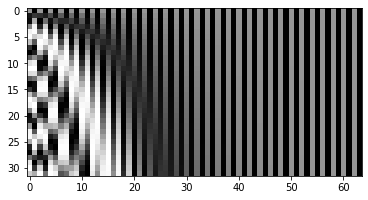

In [11]:
pos_emb = PositionalEmbedding(_MAXLEN, _HIDDEN_SIZE)
plt.imshow(
    pos_emb(torch.arange(0, 32)).cpu().numpy(),
    cmap='Greys'
)

#### The transformer encoder

In [13]:
class TransformerEmbedding(nn.Module):
    """Token and positional embedding for the Transformer."""
    def __init__(self, vocab_size: int, hidden_size: int, maxlen: int) -> None:
        super().__init__()
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.maxlen = maxlen
        self.word_embedding = nn.Embedding(
            self.vocab_size,
            self.hidden_size,
            padding_idx=0
        )
        self.pos_embedding = PositionalEmbedding(
            maxlen,
            hidden_size
        )
        
    def forward(self, X: torch.LongTensor) -> torch.FloatTensor:
        B, T = X.size()
        w_emb = self.word_embedding(X)
        p_emb = self.pos_embedding(self.get_position_ints(B, T))
        # scale by sqrt(hidden size), Vaswani et al. Section 3.4
        #emb = math.sqrt(self.hidden_size) * 
        emb = w_emb + p_emb
        return emb
    
    def get_mask(self, X: torch.LongTensor) -> torch.ByteTensor:
        """Get the mask for the transformer."""
        return (X == 0)  # (B, T)
    
    def get_position_ints(self, batch_size: int, length: int) -> torch.LongTensor:        
        X = torch.zeros(batch_size, length, dtype=torch.int64)
        X[:] = torch.arange(length)
        return X.to(self.device)

    @property
    def device(self):
        return list(self.parameters())[0].device


class DateEncoder(nn.Module):
    def __init__(self, tok_to_int) -> None:
        super().__init__()
        self.maxlen = _MAXLEN
        self.vocab_size = len(tok_to_int)
        self.hidden_size = _HIDDEN_SIZE
        self.num_layers = _NUM_LAYERS
        self.num_heads = _NUM_HEADS

        self.embedding_layer = TransformerEmbedding(
            self.vocab_size,
            self.hidden_size,
            self.maxlen
        )

        transformer_layer = nn.TransformerEncoderLayer(
            self.hidden_size,
            self.num_heads,
            dim_feedforward=self.hidden_size * self.num_heads,
        )
        self.transformer = nn.TransformerEncoder(
            transformer_layer,
            self.num_layers,
            norm=nn.LayerNorm(self.hidden_size)
        )
        
    def forward(self, X: torch.LongTensor) -> torch.FloatTensor:
        emb = self.embedding_layer(X)  # (B, T, e)
        emb_t = torch.transpose(emb, 0, 1)  # (T, B, e)
        mask = self.embedding_layer.get_mask(X)  # (B, T)
        emb_t = self.transformer(emb_t, src_key_padding_mask=mask)  # (T, B, e)
        return emb_t


class DateClassifier(nn.Module):
    def __init__(self, tok_to_int: dict, output_dim: int) -> None:
        super().__init__()
        self.output_dim = output_dim
        self.encoder = DateEncoder(tok_to_int)
        self.densor = nn.Sequential(
            nn.Linear(self.encoder.hidden_size, self.encoder.hidden_size),
            nn.ReLU(),
            nn.Linear(self.encoder.hidden_size, output_dim)
        )
    
    def forward(self, X: torch.LongTensor) -> torch.FloatTensor:
        emb = self.encoder(X)  # (T, B, e)
        last_emb = emb[-1]  # (B, e)
        logit = self.densor(last_emb)
        log_prob = F.log_softmax(logit, dim=-1)
        return log_prob

#### Hooks let us inspect the inputs/outputs of intermediate layers

For more examples and explanation.
https://blog.paperspace.com/pytorch-hooks-gradient-clipping-debugging/

In [ ]:
def decode_tensor(x: torch.LongTensor, int_to_tok: dict, strip_pad: bool = False):
    """Decode the model output, int -> char.
    Optionally remove all padding characters.
    """
    if strip_pad:
        return [int_to_tok[i] for i in x if i!=0]
    return [int_to_tok[i] for i in x]


def find_attn_modules(model: nn.Module, attn_modules: list, depth = 0):
    """Get all the attention modules in a model."""
    for i, module in enumerate(model.children()):
        if isinstance(module, nn.MultiheadAttention):
            attn_modules += [module]
        else:
            find_attn_modules(module, attn_modules, depth + 1)


class AttnModelHooks:
    def __init__(self, model) -> None:
        self.data = dict()
        self.embedding_module = model.encoder.embedding_layer
        self.output_module = model.densor
        self.attn_modules = []
        find_attn_modules(model, self.attn_modules, 0)
        
    def register(self):
        self.embedding_module.register_forward_hook(self.text_hook)
        self.output_module.register_forward_hook(self.output_hook)
        for layer in self.attn_modules:
            layer.register_forward_hook(self.attn_hook)

    def text_hook(self, module, inputs, outputs):
        assert isinstance(module, TransformerEmbedding)
        print(type(inputs))
        print(len(inputs))
        token_ids = inputs[0]
        decoded = [decode_tensor(ids, int_to_tok, strip_pad=True) for ids in token_ids]
        self.data['text'] = decoded

    def attn_hook(self, module, inputs, outputs):
        assert isinstance(module, nn.MultiheadAttention)
        attn_weights = outputs[-1]
        self.data[module] = attn_weights
    
    def output_hook(self, module, inputs, outputs):
        assert isinstance(module, nn.Sequential)
        logit = outputs[0]
        self.data['logit'] = logit

    def get_attn_data(self, idx: int) -> torch.FloatTensor:
        attn = []
        for layer in self.attn_modules:
            attn.append(self.data.get(layer)[idx])
        return torch.stack(attn, dim=0)

    def get_text_data(self, idx: int) -> List[str]:
        return self.data['text'][idx]

    def plot_attn(self, idx: int):
        attn_weights = self.get_attn_data(idx)
        text = self.get_text_data(idx)
        N = len(text)
        ticks = np.arange(N)
        for dim in range(attn_weights.size(0)):
            attn_vals = attn_weights[dim].detach().cpu().numpy()
            attn_vals = attn_vals[-N:, -N:]
            plt.imshow(attn_vals, cmap='gray', vmin=0., vmax=1.)
            plt.yticks(ticks, text)
            plt.xticks(ticks, text, rotation=45)
            plt.show()

### Train the classifier

In [102]:
model = DateClassifier(tok_to_int, data.c)
hooks = AttnModelHooks(model)
learner = Learner(data, model, loss_func=nn.NLLLoss(), opt_func=optim.Adam, metrics=[accuracy])
hooks.register()

In [103]:
learner.lr_find()
learner.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time


<class 'tuple'>
2
<class 'tuple'>
2
<class 'tuple'>
2
<class 'tuple'>
2
<class 'tuple'>
2
<class 'tuple'>
2
<class 'tuple'>
2
<class 'tuple'>
2
<class 'tuple'>
2
<class 'tuple'>
2
<class 'tuple'>
2
<class 'tuple'>
2
<class 'tuple'>
2
<class 'tuple'>
2
<class 'tuple'>
2
<class 'tuple'>
2
<class 'tuple'>
2
<class 'tuple'>
2
<class 'tuple'>
2
<class 'tuple'>
2
<class 'tuple'>
2
<class 'tuple'>
2
<class 'tuple'>
2
<class 'tuple'>
2
<class 'tuple'>
2
<class 'tuple'>
2
<class 'tuple'>
2
<class 'tuple'>
2
<class 'tuple'>
2
<class 'tuple'>
2
<class 'tuple'>
2
<class 'tuple'>
2
<class 'tuple'>
2
<class 'tuple'>
2
<class 'tuple'>
2
<class 'tuple'>
2
<class 'tuple'>
2
<class 'tuple'>
2
<class 'tuple'>
2
<class 'tuple'>
2
<class 'tuple'>
2
<class 'tuple'>
2
<class 'tuple'>
2
<class 'tuple'>
2
<class 'tuple'>
2
<class 'tuple'>
2
<class 'tuple'>
2
<class 'tuple'>
2
<class 'tuple'>
2
<class 'tuple'>
2
<class 'tuple'>
2
<class 'tuple'>
2
<class 'tuple'>
2
<class 'tuple'>
2
<class 'tuple'>
2
<class 'tu

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1622122170>
Traceback (most recent call last):
  File "/home/myen/miniconda3/envs/date/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/home/myen/miniconda3/envs/date/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/home/myen/miniconda3/envs/date/lib/python3.7/multiprocessing/process.py", line 140, in join
    res = self._popen.wait(timeout)
  File "/home/myen/miniconda3/envs/date/lib/python3.7/multiprocessing/popen_fork.py", line 48, in wait
    return self.poll(os.WNOHANG if timeout == 0.0 else 0)
  File "/home/myen/miniconda3/envs/date/lib/python3.7/multiprocessing/popen_fork.py", line 28, in poll
    pid, sts = os.waitpid(self.pid, flag)
KeyboardInterrupt: 


KeyboardInterrupt: 

In [95]:
learner.fit_one_cycle(2, max_lr=1e-2)
#learner.fit(5, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.286405,0.219345,0.873300,01:41
1,0.210547,0.202374,0.897100,01:40


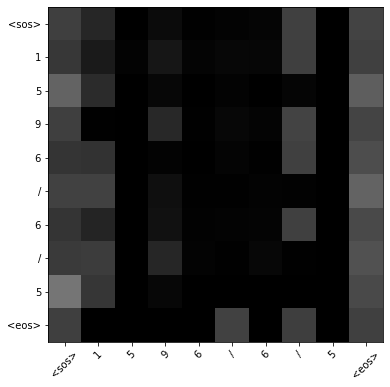

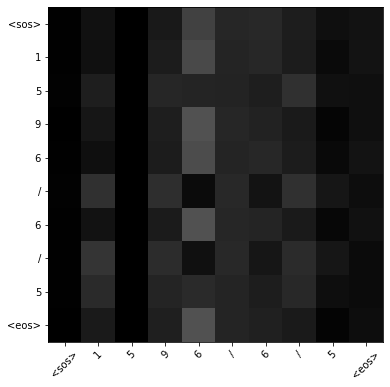

In [97]:
hooks.plot_attn(12)